In [ ]:
# default_exp model_api

# We are in dev branch so it's fine
### On dev branch:
###     dig into tokenized input shape
###     check if we need to reshape/unsqueeze input for inference only
###     don't merge this until it works
###     probably dev on local end tho it'll takes disc space
# run line by line instead of "execute all" button
### Don't just directly re-run this notebook
### But to copy it first
### Running on google colab is highly recommended

## To load weight, see the saved weight inside my cloud
## note that !wget URLs for "model.pt" doesn't work
## presumably needs to unzip the file

## My personal note
### torch_lr_finder: import error, which is dumb


### Suggestion:
#### We should try fast ai if time permits, but it's not our main goal

## ---------------

## Emotion Classification using Fine-tuned BERT model

In this tutorial, I will show to fine-tune a language model (LM) for emotion classification with code adapted from this [tutorial](https://zablo.net/blog/post/custom-classifier-on-bert-model-guide-polemo2-sentiment-analysis/) by MARCIN ZABŁOCKI. I adapted his tutorial and modified the code to suit the emotion classification task using a different BERT model. Please refer to his tutorial for more detailed explanations for each code block. I really liked his tutorial because of the attention to detail and the use of high-level libraries to take care of certain parts of the model such as training and finding a good learning rate. 

Before you get started, make sure to enable `GPU` in the runtime and be sure to 
restart the runtime in this environment after installing the `pytorch-lr-finder` library.

This tutorial is in a rough draft so if you find any issues with this tutorial or have any further questions reach out to me via [Twitter](https://twitter.com/omarsar0). 

Note that the notebook was created a little while back so if something break it's because the code is not compatible with the library changes.


### skip these dependency shxt since we should've done it when setting up the environment

In [ ]:
%%capture
!pip install transformers tokenizers pytorch-lightning

Note: you need to Restart runtime after running this code segment

In [ ]:
%%capture
!git clone https://github.com/davidtvs/pytorch-lr-finder.git && cd pytorch-lr-finder && python setup.py install

In [ ]:
import torch
from torch import nn
from typing import List
import torch.nn.functional as F
from transformers import DistilBertTokenizer, AutoTokenizer, AutoModelWithLMHead, DistilBertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
import logging
import os
from functools import lru_cache
from tokenizers import ByteLevelBPETokenizer
from tokenizers.processors import BertProcessing
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from argparse import Namespace
from sklearn.metrics import classification_report
# torch.__version__

'1.11.0+cu113'

In [ ]:
torch.__version__

## Load the Pretrained Language Model
We are first going to look at pretrained language model provided by HuggingFace models. We will use a variant of BERT, called DistilRoBERTa base. The `base` model has less parameters than the `larger` model. 

[RoBERTa](https://arxiv.org/abs/1907.11692) is a variant of of BERT which "*modifies key hyperparameters, removing the next-sentence pretraining objective and training with much larger mini-batches and learning rates*".

Knowledge distillation help to train smaller LMs with similar performance and potential.

First, let's load the tokenizer for this model:

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('distilroberta-base')

Downloading:   0%|          | 0.00/480 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Now let's load the actual model with the LM head that takes care of the prediciton for the LM. When fine-tuning we don't use the head and instead use the base model. The code below shows how to do this:

In [ ]:
model = AutoModelWithLMHead.from_pretrained("distilroberta-base")
base_model = model.base_model

/usr/local/lib/python3.7/dist-packages/transformers/models/auto/modeling_auto.py:973: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  FutureWarning,


Downloading:   0%|          | 0.00/316M [00:00<?, ?B/s]

Let's now try out the tokenizer first:

In [ ]:
text = "Elvis is the king of rock!"
enc = tokenizer.encode_plus(text)
enc.keys()

dict_keys(['input_ids', 'attention_mask'])

In [ ]:
print(enc)

{'input_ids': [0, 9682, 9578, 16, 5, 8453, 9, 3152, 328, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


`input_ids` are the numerical encoding of the tokens in the vocabulary. `attention_mask` is an addition option used when batching sequences together and you want to tell the model which tokens should be attented to ([read more](https://huggingface.co/transformers/glossary.html#attention-mask)). The attention mask information helps when dealing with variance in the size of sequences and we need a way to tell the model that we don't want to attend to the padded indices of the sequence.

We are only using `input_ids` and `attention_mask`

We need to also unsqueeze to simulate batch processing

Using DistilBertForSequenceClassification: https://huggingface.co/transformers/model_doc/distilbert.html#distilbertforsequenceclassification

In [ ]:
out = base_model(torch.tensor(enc["input_ids"]).unsqueeze(0), torch.tensor(enc["attention_mask"]).unsqueeze(0))
out[0].shape

torch.Size([1, 10, 768])

In [ ]:
## size of representation of one of the tokens 
out[0][:,0,:].shape

torch.Size([1, 768])

`torch.Size([1, 768])` represents batch_size, number of tokens in input text (lenght of tokenized text), model's output hidden size.

In [ ]:
t = "Elvis is the king of rock"
enc = tokenizer.encode_plus(t)
token_representations = base_model(torch.tensor(enc["input_ids"]).unsqueeze(0))[0][0]
print(enc["input_ids"])
print(tokenizer.decode(enc["input_ids"]))
print(f"Length: {len(enc['input_ids'])}")
print(token_representations.shape)

[0, 9682, 9578, 16, 5, 8453, 9, 3152, 2]
<s>Elvis is the king of rock</s>
Length: 9
torch.Size([9, 768])


## Building Custom Classification head on top of LM base model

Use Mish activiation function as in the one proposed in the original tutorial

In [ ]:
# from https://github.com/digantamisra98/Mish/blob/b5f006660ac0b4c46e2c6958ad0301d7f9c59651/Mish/Torch/mish.py
@torch.jit.script
def mish(input):
    import torch.nn.functional as F
    return input * torch.tanh(F.softplus(input))

class Mish(nn.Module):
    def forward(self, input):
        return mish(input)

The model we will use to do the fine-tuning

In [ ]:
class EmoModel(nn.Module):
    def __init__(self, base_model, n_classes, base_model_output_size=768, dropout=0.05):
        super().__init__()
        self.base_model = base_model

        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(base_model_output_size, base_model_output_size),
            Mish(),
            nn.Dropout(dropout),
            nn.Linear(base_model_output_size, n_classes)
        )

        for layer in self.classifier:
            if isinstance(layer, nn.Linear):
                layer.weight.data.normal_(mean=0.0, std=0.02)
                if layer.bias is not None:
                    layer.bias.data.zero_()

    def forward(self, input_, *args):
        X, attention_mask = input_
        hidden_states = self.base_model(X, attention_mask=attention_mask)

        # maybe do some pooling / RNNs... go crazy here!

        # use the <s> representation
        return self.classifier(hidden_states[0][:, 0, :])

### Pretest the model with dummy text
We want to ensure that the model is returing the right information back.

In [ ]:
classifier = EmoModel(AutoModelWithLMHead.from_pretrained("distilroberta-base").base_model, 3)

/usr/local/lib/python3.7/dist-packages/transformers/models/auto/modeling_auto.py:973: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  FutureWarning,


In [ ]:
X = torch.tensor(enc["input_ids"]).unsqueeze(0).to('cpu')
attn = torch.tensor(enc["attention_mask"]).unsqueeze(0).to('cpu')

In [ ]:
classifier((X, attn))

tensor([[ 0.1105,  0.2375, -0.1072]], grad_fn=<AddmmBackward0>)

## Prepare your dataset for fine-tuning

In [ ]:
!mkdir -p tokenizer

In [ ]:
## load pretrained tokenizer information
tokenizer.save_pretrained("tokenizer")

('tokenizer/tokenizer_config.json',
 'tokenizer/special_tokens_map.json',
 'tokenizer/vocab.json',
 'tokenizer/merges.txt',
 'tokenizer/added_tokens.json',
 'tokenizer/tokenizer.json')

In [ ]:
!ls tokenizer

merges.txt		 tokenizer_config.json	vocab.json
special_tokens_map.json  tokenizer.json


Implement CollateFN using fast tokenizers.
This function basically takes care of proper tokenization and batches of sequences. This way you don't need to create your batches manually. Find out more about Tokenizers [here](https://github.com/huggingface/tokenizers/tree/master/bindings/python).

In [ ]:
# needed for tokenize the user input
class TokenizersCollateFn:
    def __init__(self, max_tokens=512):

        # I still need this to parse the input
        # try to figure out where to store these tokens
        # instead of re-download it every time
        # reload is probably fine if the model is on AWS?
        ## RoBERTa uses BPE tokenizer similar to GPT
        t = ByteLevelBPETokenizer(
            "tokenizer/vocab.json",
            "tokenizer/merges.txt"
        )
        t._tokenizer.post_processor = BertProcessing(
            ("</s>", t.token_to_id("</s>")),
            ("<s>", t.token_to_id("<s>")),
        )
        t.enable_truncation(max_tokens)
        t.enable_padding(length=max_tokens, pad_id=t.token_to_id("<pad>"))
        self.tokenizer = t

    def __call__(self, batch):
        encoded = self.tokenizer.encode_batch([x[0] for x in batch])
        sequences_padded = torch.tensor([enc.ids for enc in encoded])
        attention_masks_padded = torch.tensor([enc.attention_mask for enc in encoded])
        labels = torch.tensor([x[1] for x in batch])
        
        return (sequences_padded, attention_masks_padded), labels

## Getting the Data and Preview it
Below we are going to load the data and show you how to create the splits. However, we don't need to split the data manually becuase I have already created the splits and stored those files seperately which you can quickly download below:

In [ ]:
!wget https://www.dropbox.com/s/ikkqxfdbdec3fuj/test.txt
!wget https://www.dropbox.com/s/1pzkadrvffbqw6o/train.txt
!wget https://www.dropbox.com/s/2mzialpsgf9k5l3/val.txt

--2022-07-04 12:51:43--  https://www.dropbox.com/s/ikkqxfdbdec3fuj/test.txt
Resolving www.dropbox.com (www.dropbox.com)... 162.125.4.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.4.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/ikkqxfdbdec3fuj/test.txt [following]
--2022-07-04 12:51:43--  https://www.dropbox.com/s/raw/ikkqxfdbdec3fuj/test.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucbaec52c9833bf780517d882e40.dl.dropboxusercontent.com/cd/0/inline/BoZN5Yhoh4odNGswTqol1TyJvJds0cGZJ9yCO7e_SSKoDQQHx0nGoN_RdA9eK67l3PeuntcfZsX8KXqZoBEppu28WtaRFrOtxH-93B1jkcr_2EiLwsftygxqHRXg2pRXZ_FrchY4gEo_eeLulOzD43_xh9k7kdBLZJr4_sbnNaMBxg/file# [following]
--2022-07-04 12:51:43--  https://ucbaec52c9833bf780517d882e40.dl.dropboxusercontent.com/cd/0/inline/BoZN5Yhoh4odNGswTqol1TyJvJds0cGZJ9yCO7e_SSKoDQQHx0nGoN_RdA9eK67l3PeuntcfZsX8KXqZ

In [ ]:
## export the datasets as txt files
## EXERCISE: Change this to an address

train_path = "train.txt"
test_path = "test.txt"
val_path = "val.txt"

## emotion labels
label2int = {
  "sadness": 0,
  "joy": 1,
  "love": 2,
  "anger": 3,
  "fear": 4,
  "surprise": 5
}

emotions = [ "sadness", "joy", "love", "anger", "fear", "surprise"]

### A Quick Look at the dataset
Below is a few code sniphets to get a good idea of the dataset we are using here. You can skip this whole subsection if you like.

In [ ]:
!wget https://www.dropbox.com/s/607ptdakxuh5i4s/merged_training.pkl

--2022-07-04 12:51:47--  https://www.dropbox.com/s/607ptdakxuh5i4s/merged_training.pkl
Resolving www.dropbox.com (www.dropbox.com)... 162.125.4.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.4.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/607ptdakxuh5i4s/merged_training.pkl [following]
--2022-07-04 12:51:47--  https://www.dropbox.com/s/raw/607ptdakxuh5i4s/merged_training.pkl
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc615c650bddae1f31315dbe01be.dl.dropboxusercontent.com/cd/0/inline/BoagSRMtLxoafwVPfktiUwWXyPv1txKcLgIQtcfekgRGSvIvDBDFdctfIdLWCtunrOCho3rkNJlJhmpwMM8GgveZkygqHr_2Ytl0EbFpB1APVPuDpNdBYvS2ymoqBKLvuia8VDeK1F5vgaEs2n1_o-qjKgeds8LCSPTwbkN5gwFgNA/file# [following]
--2022-07-04 12:51:47--  https://uc615c650bddae1f31315dbe01be.dl.dropboxusercontent.com/cd/0/inline/BoagSRMtLxoafwVPfktiUwWXyPv1txKcLgIQtcfekgRGSvI

In [ ]:
import pickle

## helper function
def load_from_pickle(directory):
    return pickle.load(open(directory,"rb"))

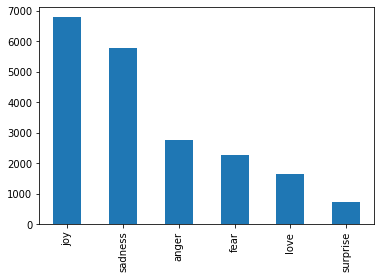

In [ ]:
data = load_from_pickle(directory="merged_training.pkl")

## using a sample
data= data[data["emotions"].isin(emotions)]


data = data.sample(n=20000);

data.emotions.value_counts().plot.bar()

In [ ]:
data.count()

text        20000
emotions    20000
dtype: int64

Data has been preprocessed already, using technique from this paper: https://www.aclweb.org/anthology/D18-1404/

In [ ]:
data.head()

,text,emotions
54470,i feel most relieved,joy
51736,ill talk to most anyone as long as im not feel...,anger
49002,i feel rather listless and floppy and really o...,sadness
18208,i climbed up on that tank feeling like i belon...,joy
85461,i read from a site stating that if we feel lon...,sadness


In [ ]:
## reset index
data.reset_index(drop=True, inplace=True)

In [ ]:
## check unique emotions in the dataset
data.emotions.unique()

array(['joy', 'anger', 'sadness', 'fear', 'surprise', 'love'],
      dtype=object)

## Split the data and store into individual text files

If you are using your own dataset and want to split it for training, you can uncomment the code below. Otherwise, just skip it. 

In [ ]:
## uncomment the code below to generate the text files for your train, val, and test datasets.

'''
from sklearn.model_selection import train_test_split
import numpy as np

# Creating training and validation sets using an 80-20 split
input_train, input_val, target_train, target_val = train_test_split(data.text.to_numpy(), 
                                                                    data.emotions.to_numpy(), 
                                                                    test_size=0.2)

# Split the validataion further to obtain a holdout dataset (for testing) -- split 50:50
input_val, input_test, target_val, target_test = train_test_split(input_val, target_val, test_size=0.5)


## create a dataframe for each dataset
train_dataset = pd.DataFrame(data={"text": input_train, "class": target_train})
val_dataset = pd.DataFrame(data={"text": input_val, "class": target_val})
test_dataset = pd.DataFrame(data={"text": input_test, "class": target_test})
final_dataset = {"train": train_dataset, "val": val_dataset , "test": test_dataset }

train_dataset.to_csv(train_path, sep=";",header=False, index=False)
val_dataset.to_csv(test_path, sep=";",header=False, index=False)
test_dataset.to_csv(val_path, sep=";",header=False, index=False)
'''

'\nfrom sklearn.model_selection import train_test_split\nimport numpy as np\n\n# Creating training and validation sets using an 80-20 split\ninput_train, input_val, target_train, target_val = train_test_split(data.text.to_numpy(), \n                                                                    data.emotions.to_numpy(), \n                                                                    test_size=0.2)\n\n# Split the validataion further to obtain a holdout dataset (for testing) -- split 50:50\ninput_val, input_test, target_val, target_test = train_test_split(input_val, target_val, test_size=0.5)\n\n\n## create a dataframe for each dataset\ntrain_dataset = pd.DataFrame(data={"text": input_train, "class": target_train})\nval_dataset = pd.DataFrame(data={"text": input_val, "class": target_val})\ntest_dataset = pd.DataFrame(data={"text": input_test, "class": target_test})\nfinal_dataset = {"train": train_dataset, "val": val_dataset , "test": test_dataset }\n\ntrain_dataset.to_csv(tra

## Create the Dataset object

Create the Dataset object that will be used to load the different datasets.

In [ ]:
class EmoDataset(Dataset):
    def __init__(self, path):
        super().__init__()
        self.data_column = "text"
        self.class_column = "class"
        self.data = pd.read_csv(path, sep=";", header=None, names=[self.data_column, self.class_column],
                               engine="python")

    def __getitem__(self, idx):
        return self.data.loc[idx, self.data_column], label2int[self.data.loc[idx, self.class_column]]

    def __len__(self):
        return self.data.shape[0]

Sanity check

In [ ]:
ds = EmoDataset(train_path)
ds[19]

('i now feel compromised and skeptical of the value of every unit of work i put in',
 4)

## Training with PyTorchLightning

[PyTorchLightning](https://www.pytorchlightning.ai/) is a library that abstracts the complexity of training neural networks with PyTorch. It is built on top of PyTorch and simplifies training.

![](https://pytorch-lightning.readthedocs.io/en/latest/_images/pt_to_pl.png)

In [ ]:
## Methods required by PyTorchLightning

class TrainingModule(pl.LightningModule):
    def __init__(self, hparams):
        super().__init__()
        self.model = EmoModel(AutoModelWithLMHead.from_pretrained("distilroberta-base").base_model, len(emotions))
        self.loss = nn.CrossEntropyLoss() ## combines LogSoftmax() and NLLLoss()
        #self.hparams = hparams
        self.hparams.update(vars(hparams))

    def step(self, batch, step_name="train"):
        X, y = batch
        loss = self.loss(self.forward(X), y)
        loss_key = f"{step_name}_loss"
        tensorboard_logs = {loss_key: loss}

        return { ("loss" if step_name == "train" else loss_key): loss, 'log': tensorboard_logs,
               "progress_bar": {loss_key: loss}}

    def forward(self, X, *args):
        return self.model(X, *args)

    def training_step(self, batch, batch_idx):
        return self.step(batch, "train")
    
    def validation_step(self, batch, batch_idx):
        return self.step(batch, "val")

    def validation_end(self, outputs: List[dict]):
        loss = torch.stack([x["val_loss"] for x in outputs]).mean()
        return {"val_loss": loss}
        
    def test_step(self, batch, batch_idx):
        return self.step(batch, "test")
    
    def train_dataloader(self):
        return self.create_data_loader(self.hparams.train_path, shuffle=True)

    def val_dataloader(self):
        return self.create_data_loader(self.hparams.val_path)

    def test_dataloader(self):
        return self.create_data_loader(self.hparams.test_path)
                
    def create_data_loader(self, ds_path: str, shuffle=False):
        return DataLoader(
                    EmoDataset(ds_path),
                    batch_size=self.hparams.batch_size,
                    shuffle=shuffle,
                    collate_fn=TokenizersCollateFn()
        )
        
    @lru_cache()
    def total_steps(self):
        return len(self.train_dataloader()) // self.hparams.accumulate_grad_batches * self.hparams.epochs

    def configure_optimizers(self):
        ## use AdamW optimizer -- faster approach to training NNs
        ## read: https://www.fast.ai/2018/07/02/adam-weight-decay/
        optimizer = AdamW(self.model.parameters(), lr=self.hparams.lr)
        lr_scheduler = get_linear_schedule_with_warmup(
                    optimizer,
                    num_warmup_steps=self.hparams.warmup_steps,
                    num_training_steps=self.total_steps(),
        )
        return [optimizer], [{"scheduler": lr_scheduler, "interval": "step"}]

## Finding Learning rate for the model

The code below aims to obtain valuable information about the optimal learning rate during a pretraining run. Determine boundary and increase the leanring rate linearly or exponentially.

More: https://github.com/davidtvs/pytorch-lr-finder

In [ ]:
!ls

merged_training.pkl  sample_data  tokenizer  val.txt
pytorch-lr-finder    test.txt	  train.txt


In [ ]:
!cd pytorch-lr-finder && python setup.py install

running install
running bdist_egg
running egg_info
writing torch_lr_finder.egg-info/PKG-INFO
writing dependency_links to torch_lr_finder.egg-info/dependency_links.txt
writing requirements to torch_lr_finder.egg-info/requires.txt
writing top-level names to torch_lr_finder.egg-info/top_level.txt
adding license file 'LICENSE'
writing manifest file 'torch_lr_finder.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/torch_lr_finder
copying build/lib/torch_lr_finder/__init__.py -> build/bdist.linux-x86_64/egg/torch_lr_finder
copying build/lib/torch_lr_finder/lr_finder.py -> build/bdist.linux-x86_64/egg/torch_lr_finder
byte-compiling build/bdist.linux-x86_64/egg/torch_lr_finder/__init__.py to __init__.cpython-37.pyc
byte-compiling build/bdist.linux-x86_64/egg/torch_lr_finder/lr_finder.py to lr_finder.cpython-37.pyc
creating build/bdist.linux-x86_64/egg/EG

In [ ]:
!cd pytorch-lr-finder/ && ls

build		 examples  README.md  torch_lr_finder
CONTRIBUTING.md  images    setup.py   torch_lr_finder.egg-info
dist		 LICENSE   tests


#### torch_lr_finder (below 3 blocks) has import error -> not working when i actually run it

In [ ]:
import torch_lr_finder

In [ ]:
from torch_lr_finder import *

In [ ]:
lr=0.1 ## uper bound LR
#from torch_lr_finder import LRFinder
hparams_tmp = Namespace(
    train_path=train_path,
    val_path=val_path,
    test_path=test_path,
    batch_size=16,
    warmup_steps=100,
    epochs=1,
    lr=lr,
    accumulate_grad_batches=1,
)
module = TrainingModule(hparams_tmp)
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(module.parameters(), lr=5e-7) ## lower bound LR
# lr_finder = LRFinder(module, optimizer, criterion, device="cuda")
# lr_finder.range_test(module.train_dataloader(), end_lr=100, num_iter=100, accumulation_steps=hparams_tmp.accumulate_grad_batches)
# lr_finder.plot()
# lr_finder.reset()

/usr/local/lib/python3.7/dist-packages/transformers/models/auto/modeling_auto.py:973: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
lr = 1e-4 
lr

0.0001

In [ ]:
#lr_finder.plot(show_lr=lr)

## Training the Emotion Classifier

#### This is what we actually ended up running, don't be confused by the above codes which looked like the one here

In [ ]:
hparams = Namespace(
    train_path=train_path,
    val_path=val_path,
    test_path=test_path,
    batch_size=32,
    warmup_steps=100,
    epochs=1,
    lr=lr,
    accumulate_grad_batches=1
)
module = TrainingModule(hparams)

/usr/local/lib/python3.7/dist-packages/transformers/models/auto/modeling_auto.py:973: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  FutureWarning,


In [ ]:
## garbage collection
import gc; gc.collect()
torch.cuda.empty_cache()

In [ ]:
## train roughly for about 10-15 minutes with GPU enabled.
trainer = pl.Trainer(gpus=1, max_epochs=hparams.epochs, progress_bar_refresh_rate=10,
                     accumulate_grad_batches=hparams.accumulate_grad_batches)

trainer.fit(module)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:97: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=10)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /content/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation tor

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
with torch.no_grad():
    progress = ["/", "-", "\\", "|", "/", "-", "\\", "|"]
    module.eval()
    true_y, pred_y = [], []
    for i, batch_ in enumerate(module.test_dataloader()):
        (X, attn), y = batch_
        #batch = (X.cuda(), attn.cuda()) # who put this stupid line here, which messed up the devices
        batch = X, attn
        print(progress[i % len(progress)], end="\r")
        # but now it takes forever to calculate a single epoch
        y_pred = torch.argmax(module(batch), dim=1)
        true_y.extend(y.cpu())
        pred_y.extend(y_pred.cpu())
print("\n" + "_" * 80)
print(classification_report(true_y, pred_y, target_names=label2int.keys(), digits=len(emotions)))


________________________________________________________________________________
              precision    recall  f1-score   support

     sadness   0.965458  0.962134  0.963793       581
         joy   0.957101  0.930935  0.943837       695
        love   0.787709  0.886792  0.834320       159
       anger   0.902778  0.945455  0.923623       275
        fear   0.893805  0.901786  0.897778       224
    surprise   0.826923  0.651515  0.728814        66

    accuracy                       0.926000      2000
   macro avg   0.888962  0.879770  0.882027      2000
weighted avg   0.927207  0.926000  0.925894      2000



### Let's actually save the result in a .txt file

In [ ]:
# this would throw an error, we have to "mount the drive" first, see the cells below
PATH

'drive/MyDrive/AI_sheng/emo_0.pt'

### Always remember to change the newly saved file name to avoid over-writing the previous records

In [ ]:
with open("drive/MyDrive/AI_sheng/emo_0_result.txt", "w") as f:
  for line in classification_report(true_y, pred_y, target_names=label2int.keys(), digits=len(emotions)):
    f.write(line)
  f.close()

In [ ]:
!nvidia-smi

Mon Jul  4 13:50:54 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    33W /  70W |   1428MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
"""
What we need is to save the trained model (weights &)


to save model:
  module.model (?) # see TrainingModule class



"""

'\nWhat we need is to save the trained model (weights &)\n\n\nto save model:\n  module.model (?) # see TrainingModule class\n\n\n\n'

In [ ]:
"""
# to load the model, the class definition would not be saved in the file
# and therefore should be recorded somewhere else
PATH = ...
torch.save(module.model.state_dict(), PATH)

"""

In [ ]:
# to verify if it works
"""
model = ...
model.load(PATH)
model.eval() # important to not change the params in the model
"""


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls drive/MyDrive/AI_sheng

「RoBERTa_Fine_Tuning_Emotion_classification.ipynb」的副本


In [ ]:
print("Model's state_dict:")
for param_tensor in module.model.state_dict():
    print(param_tensor, "\t", module.model.state_dict()[param_tensor].size())

# # Print optimizer's state_dict
# print("Optimizer's state_dict:")
# for var_name in optimizer.state_dict():
#     print(var_name, "\t", optimizer.state_dict()[var_name])

Model's state_dict:
base_model.embeddings.position_ids 	 torch.Size([1, 514])
base_model.embeddings.word_embeddings.weight 	 torch.Size([50265, 768])
base_model.embeddings.position_embeddings.weight 	 torch.Size([514, 768])
base_model.embeddings.token_type_embeddings.weight 	 torch.Size([1, 768])
base_model.embeddings.LayerNorm.weight 	 torch.Size([768])
base_model.embeddings.LayerNorm.bias 	 torch.Size([768])
base_model.encoder.layer.0.attention.self.query.weight 	 torch.Size([768, 768])
base_model.encoder.layer.0.attention.self.query.bias 	 torch.Size([768])
base_model.encoder.layer.0.attention.self.key.weight 	 torch.Size([768, 768])
base_model.encoder.layer.0.attention.self.key.bias 	 torch.Size([768])
base_model.encoder.layer.0.attention.self.value.weight 	 torch.Size([768, 768])
base_model.encoder.layer.0.attention.self.value.bias 	 torch.Size([768])
base_model.encoder.layer.0.attention.output.dense.weight 	 torch.Size([768, 768])
base_model.encoder.layer.0.attention.output.dense

In [ ]:
# save the whole damn thing, not just the weight, but the hyperparams, loss, etc
# Additional information
EPOCH = 1
PATH = "drive/MyDrive/AI_sheng/emo_0.pt"
LOSS = 0.

torch.save({
            'epoch': EPOCH,
            'model_state_dict': module.model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': LOSS,
            }, PATH)

In [ ]:
# test load model
# we need the architecture
model = EmoModel(AutoModelWithLMHead.from_pretrained("distilroberta-base").base_model, len(emotions))
optimizer = AdamW(model.parameters(), lr=0.0001)

checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']

model.eval()
# - or -
# model.train()

/usr/local/lib/python3.7/dist-packages/transformers/models/auto/modeling_auto.py:973: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


EmoModel(
  (base_model): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,

### Save for inference only as well to reduce the file size

In [ ]:
PATH

'drive/MyDrive/AI_sheng/emo_0.pt'

In [ ]:
torch.save(module.model, 'drive/MyDrive/AI_sheng/emo_0_inference_only.pt')

In [ ]:
# test load model
# we need the architecture
model = EmoModel(AutoModelWithLMHead.from_pretrained("distilroberta-base").base_model, len(emotions))
optimizer = AdamW(model.parameters(), lr=0.0001)

checkpoint = torch.load("drive/MyDrive/AI_sheng/emo_0.pt")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']

model.eval()
# - or -
# model.train()

/usr/local/lib/python3.7/dist-packages/transformers/models/auto/modeling_auto.py:973: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


EmoModel(
  (base_model): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,

In [ ]:
# previously used test batch to test if the reloaded model works
batch

(tensor([[   0,  118,  376,  ...,    1,    1,    1],
         [   0,  118,   21,  ...,    1,    1,    1],
         [   0,  757, 2157,  ...,    1,    1,    1],
         ...,
         [   0,  118,  619,  ...,    1,    1,    1],
         [   0,  757, 2157,  ...,    1,    1,    1],
         [   0,  118,  619,  ...,    1,    1,    1]]),
 tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]))

In [ ]:
# model reload works (inference only works)
model.forward(batch)

tensor([[-0.9080, -1.2302, -0.9013,  5.8108, -0.3313, -1.6975],
        [-2.0946,  6.4397,  0.3476, -1.8304, -1.9126, -1.6221],
        [-1.0167, -1.4537, -2.5131, -0.5782,  6.0331, -0.0138],
        [ 6.1555, -0.9121, -1.5822,  0.0782, -0.4525, -1.8345],
        [ 6.1081, -0.0588, -1.4681, -0.5297, -0.9191, -1.9302],
        [ 5.9176, -0.2496, -0.8827,  0.4110, -1.6411, -2.4032],
        [-1.5229,  2.6171,  4.4723, -2.0810, -2.4527, -2.6025],
        [-1.4750,  2.2911,  4.3958, -1.4681, -2.4978, -2.7022],
        [-2.1249, -1.7336, -1.9561,  2.9887,  2.9735,  0.1342],
        [-0.8134, -1.6481, -1.5137,  5.8931,  0.3576, -1.3272],
        [ 5.9923, -1.1148, -1.9877, -0.3512,  0.3510, -1.4085],
        [ 1.0029,  0.2793,  1.0631,  3.3292, -2.5348, -2.9683],
        [-0.6613, -1.4232, -1.0356,  5.8153, -0.2930, -1.5194],
        [-1.8507,  6.3146, -0.0732, -1.9502, -2.2076, -0.7117],
        [-1.8714,  6.5112,  0.0234, -2.0143, -1.5364, -1.5565],
        [-1.5251, -0.9851, -2.0907, -1.8

## Below codes are newly added for exporting & api

### Let's just start from here and export the passed codes
#### don't train the whole model unless it's necessary

In [ ]:
# exporting this won't work
# since they're locally imported
def setup_imports():
    """
    import everything is slow, try to fix it after we nailed down the data classes
    """
    import torch
    from torch import nn
    from typing import List
    import torch.nn.functional as F
    from transformers import DistilBertTokenizer, AutoTokenizer, AutoModelWithLMHead, DistilBertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
    import logging
    import os
    from functools import lru_cache
    from tokenizers import ByteLevelBPETokenizer
    from tokenizers.processors import BertProcessing
    import pytorch_lightning as pl
    from torch.utils.data import DataLoader, Dataset
    import pandas as pd
    from argparse import Namespace
    from sklearn.metrics import classification_report
    print(torch.__version__)
    return True

In [ ]:
#export 
# necessary evil
import torch
import torch.nn as nn
import torch.nn.functional as F
import os

In [ ]:
#export
# from https://github.com/digantamisra98/Mish/blob/b5f006660ac0b4c46e2c6958ad0301d7f9c59651/Mish/Torch/mish.py
@torch.jit.script
def mish(input):
    return input * torch.tanh(F.softplus(input))

class Mish(nn.Module):
    def forward(self, input):
        return mish(input)

In [ ]:
# export
class EmoModel(nn.Module):
    def __init__(self, base_model, n_classes, base_model_output_size=768, dropout=0.05):
        super().__init__()
        self.base_model = base_model

        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(base_model_output_size, base_model_output_size),
            Mish(),
            nn.Dropout(dropout),
            nn.Linear(base_model_output_size, n_classes)
        )

        for layer in self.classifier:
            if isinstance(layer, nn.Linear):
                layer.weight.data.normal_(mean=0.0, std=0.02)
                if layer.bias is not None:
                    layer.bias.data.zero_()

    def forward(self, input_, *args):
        X, attention_mask = input_
        hidden_states = self.base_model(X, attention_mask=attention_mask)
        # customize here
        # use the <s> representation
        return self.classifier(hidden_states[0][:, 0, :])

#### write the label2int map since it's used everywhere

In [ ]:
# export
label2int = {
    "sadness": 0,
    "joy": 1,
    "love": 2,
    "anger": 3,
    "fear": 4,
    "surprise": 5
}

In [ ]:
# export
def get_model(PATH, pretrained=True, inference_only=True, lr=0.0001, default_model=None):
    if PATH[-3:] != ".pt" and PATH[-4:] != ".pth":
        print("Unable to load pretrained model")
        return None

    # show warning message when it's inference only but lr has been changed
    if inference_only == True and lr != 0.0001:
        print("Warning: the loaded model is for inference only, so there's no optimizer for the changed learning rate")
    # model = EmoModel(AutoModelWithLMHead.from_pretrained("distilroberta-base").base_model, len(emotions))
    # emotions = ["sadness", "joy", "love", "anger", "fear", "surprise"], len(label2int) would work as well
    model = None
    if default_model is None:
        from transformers import AutoModelWithLMHead
        model = EmoModel(AutoModelWithLMHead.from_pretrained("distilroberta-base").base_model, 6)
    else:
        # set model to user-defined model
        model = default_model

    # if you want to train it from scratch
    if pretrained == False:
        return model

    checkpoint = torch.load(PATH)

    if inference_only:
        # model would not be subscriptable
        model.load_state_dict(checkpoint)
        model.eval()
    else:
        # lr: learning rate, adjustable
        from transformers import AdamW
        optimizer = AdamW(model.parameters(), lr=lr)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        model.train()

    return model

### For inference only, we should just take advantage of the class TokenizersCollateFN() class defined above

In [ ]:
# export
# save the pretrained token
def load_tokenizer():
    from tokenizers import AutoTokenizer
    tokenizer = AutoTokenizer.from_pretrained('distilroberta-base')
    # -p, --parent, no error if it exists, make parent directory as necessary
    os.system("mkdir -p tokenizer")
    tokenizer.save_pretrained("tokenizer")

def setup_tokenizer():
    # if there's no previous file/record
    # should we check if there are missing files given that it's previously downloaded?
    if not os.path.isdir("tokenizer"):
        load_tokenizer()

    else: # content of previously download files is not complete
        checklist = ['merges.txt', 'special_tokens_map.json', 'tokenizer.json', 'tokenizer_config.json', 'vocab.json']
        # check existing files
        # existing_files = os.walk(os.path.join(os.getcwd(), "tokenizer"))
        existing_files = list(os.walk("tokenizer"))[0][2]
        # os.walk() won't messed up the order of the searched files,
        # so, we can just use "==" operator
        if existing_files != checklist:
            # clean the previously download ones
            os.system("rmdir -rf tokenizer")
            # and, re-download it
            load_tokenizer()

In [ ]:
#export
def print_emotion(output, print_emo=True):
    # output = model.forward(input)
    import torch
    idx = torch.argmax(output, dim=1)
    from EMO_AI.model_api import label2int
    for key in label2int:
        if label2int[key] == idx:
            if print_emo == True:
                print("Emotion: %s" % key)
            break
    return key

## Above are stable

In [ ]:
from EMO_AI.model_api import *
from EMO_AI.data_process import *

In [ ]:
# change this
PATH = "C:"+chr(92)+"Users"+chr(92)+"Kelvin"+chr(92)+"Desktop"+chr(92)+"ai_sheng"+chr(92)+"emo_0.pt"
model = get_model(PATH, inference_only=False)

c:\Users\Kelvin\anaconda3\envs\AI_sheng\lib\site-packages\transformers\models\auto\modeling_auto.py:973: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  FutureWarning,
c:\Users\Kelvin\anaconda3\envs\AI_sheng\lib\site-packages\transformers\optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
text = "This love has taken it's toll on me"

In [ ]:
tokenizer = get_tokenizer()

### Should we add tokenizer as an attribute of the model
### for potential more concise high-level API?

### Try to lessen code to get model output

In [ ]:
#export
# mainly about not re-writing with torch.no_grad(), model.eval() again
def get_output(text, model, tokenizer=None, return_tensor=False, print_emo=False):
    # we should add try/Except error handling for "model" argument
    # , but i consider it to be ugly
    import torch
    with torch.no_grad():
        model.eval()
        # we have control flow in convert_text_to_tensor()
        out = model(convert_text_to_tensor(text, tokenizer))
    # put it right here to enable "print_emo" argument
    emo_label = print_emotion(out, print_emo=print_emo)
    if return_tensor == True:
        return out
    # else, return emotion label (a string)
    return emo_label
    

In [ ]:
result = get_output(text, model, tokenizer)
# deliberately not to use defined tokenizer
result_tensor = get_output(text, model, return_tensor=True, print_emo=True)
print(result, result_tensor)

Emotion: sadness
sadness tensor([[ 2.2319,  0.6387,  0.6452,  1.6908, -1.7631, -3.2787]])
